In [1]:
import sys, os

# Add the project root directory to sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

print(project_root)  # Just to verify path added


d:\envs\Vehicle_RE_ID


In [45]:
from src.dataset import VeRiDataset
from src.sampler import RandomIdentitySampler
from src.model import ReIDModel
from src.losses import TripletLoss
import os
import random
import xml.etree.ElementTree as ET
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, Sampler
from torchvision import transforms, models
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from tqdm import tqdm
import torch.optim as optim
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000029A35130220>
Traceback (most recent call last):
  File "d:\envs\Vehicle_RE_ID\Re_ID\Lib\site-packages\torch\utils\data\dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "d:\envs\Vehicle_RE_ID\Re_ID\Lib\site-packages\torch\utils\data\dataloader.py", line 1562, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
                                   ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


In [3]:
print(os.getcwd())

d:\envs\Vehicle_RE_ID\notebooks


In [4]:
from lxml import etree

with open("D:/envs/Vehicle_RE_ID/data/VeRi/train_label.xml", "rb") as f:
    xml_bytes = f.read()

with open("D:/envs/Vehicle_RE_ID/data/VeRi/test_label.xml", "rb") as g:
    xml_bytes_ = g.read()

xml_text = xml_bytes.decode("gb2312", errors="ignore")
root = etree.fromstring(xml_text.encode("utf-8"))

xml_text_ = xml_bytes_.decode("gb2312", errors="ignore")
root_ = etree.fromstring(xml_text_.encode("utf-8"))

print(root.tag)
print(len(root.findall(".//Item")))

print("TestingImages")
print(len(root_.findall(".//Item")))


TrainingImages
37746
TestingImages
11579


In [5]:
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Pad(10),
    transforms.RandomCrop((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),      # resize to same as training
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [6]:
dataset_root = 'D:/envs/Vehicle_RE_ID/data/VeRi/'

train_dataset = VeRiDataset(dataset_root, split="train", transform=transform_train)
print(len(train_dataset))

test_dataset = VeRiDataset(dataset_root, split="test", transform=transform_train)
print(len(test_dataset))


Loaded VeRi split: train
  Total images: 37746
  Unique vehicle IDs: 575
  Cameras: 20
  Vehicle ID range (remapped): 0 → 574

37746

Loaded VeRi split: test
  Total images: 11579
  Unique vehicle IDs: 200
  Cameras: 19
  Vehicle ID range (remapped): 0 → 199

11579


In [7]:
train_dataset[1000]

(tensor([[[ 0.6906,  0.6906,  0.6734,  ..., -2.1179, -2.1179, -2.1179],
          [ 0.6906,  0.6906,  0.6734,  ..., -2.1179, -2.1179, -2.1179],
          [ 0.6906,  0.6906,  0.6734,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[ 0.8529,  0.8529,  0.8354,  ..., -2.0357, -2.0357, -2.0357],
          [ 0.8529,  0.8529,  0.8354,  ..., -2.0357, -2.0357, -2.0357],
          [ 0.8529,  0.8529,  0.8179,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[ 0.9668,  0.9668,  0.9668,  ..., -1.8044, -1.8044, -1.8044],
          [ 0.9842,  0.9842,

In [8]:
test_dataset[100]

(tensor([[[-2.1179, -2.1179, -1.3473,  ...,  0.2453,  0.2282,  0.2282],
          [-2.1179, -2.1179, -1.3302,  ...,  0.2453,  0.2282,  0.2282],
          [-2.1179, -2.1179, -1.3130,  ...,  0.2453,  0.2282,  0.2282],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -1.2304,  ...,  0.3452,  0.3452,  0.3452],
          [-2.0357, -2.0357, -1.2129,  ...,  0.3452,  0.3452,  0.3452],
          [-2.0357, -2.0357, -1.1954,  ...,  0.3452,  0.3452,  0.3452],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -0.9330,  ...,  0.7576,  0.7228,  0.7054],
          [-1.8044, -1.8044,

In [9]:
# ✅ For query set — filter from test samples
query_list_path = os.path.join(dataset_root, "name_query.txt")
with open(query_list_path, "r") as f:
    query_names = [line.strip() for line in f.readlines()]

query_samples = [s for s in test_dataset.samples if os.path.basename(s[0]) in query_names]
gallery_samples = [s for s in test_dataset.samples if os.path.basename(s[0]) not in query_names]

In [10]:
# Create dataset instances manually using the same transform
query_dataset = torch.utils.data.Subset(test_dataset, range(len(query_samples)))
query_dataset.samples = query_samples

gallery_dataset = torch.utils.data.Subset(test_dataset, range(len(gallery_samples)))
gallery_dataset.samples = gallery_samples

In [11]:
print("Total Training samples:", len(train_dataset))
unique_vids = len(set([vid for _, vid, _ in train_dataset.samples]))
print("Unique vehicle IDs:", unique_vids)

batch_size = 32
num_instances = 4
P = batch_size // num_instances
print(f"num_pids_per_batch = {P}")

#---------------------------------------------------------------------------------

print("\nTest samples:", len(test_dataset))

#---------------------------------------------------------------------------------

print("\nQuery samples:", len(query_dataset))

#---------------------------------------------------------------------------------

print("\nGallery samples:", len(gallery_dataset))


Total Training samples: 37746
Unique vehicle IDs: 575
num_pids_per_batch = 8

Test samples: 11579

Query samples: 1678

Gallery samples: 9901


In [12]:
batch_size = 32
num_instances = 4  # K
sampler = RandomIdentitySampler(train_dataset, batch_size, num_instances)
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=4, drop_last=True)

query_loader = DataLoader(query_dataset, batch_size=32, shuffle=False, num_workers=4)

gallery_loader = DataLoader(gallery_dataset, batch_size=32, shuffle=False, num_workers=4)


In [13]:
print(f"Train samples: {len(train_dataset)}")
print(f"Query samples: {len(query_dataset)}")
print(f"Gallery samples: {len(gallery_dataset)}")

Train samples: 37746
Query samples: 1678
Gallery samples: 9901


In [14]:
for imgs, pids, camids in train_loader:
    print("Batch PIDs:", pids)
    break

Batch PIDs: tensor([103, 103, 103, 103,  58,  58,  58,  58, 378, 378, 378, 378, 375, 375,
        375, 375, 354, 354, 354, 354, 319, 319, 319, 319, 245, 245, 245, 245,
        535, 535, 535, 535])


In [15]:
batch = next(iter(train_loader))
print("Batch PIDs:", batch[1])

Batch PIDs: tensor([569, 569, 569, 569, 280, 280, 280, 280, 410, 410, 410, 410, 563, 563,
        563, 563, 419, 419, 419, 419,   7,   7,   7,   7, 337, 337, 337, 337,
        530, 530, 530, 530])


In [16]:
import torch
print(torch.__version__)
print("CUDA available:", torch.cuda.is_available())


2.5.1+cu121
CUDA available: True


In [17]:
num_classes=len(set([v for _, v, _ in train_dataset.samples]))
print(num_classes)

575


In [18]:
#Create Optimizer and Scheduler

model = ReIDModel(num_classes=len(set([v for _, v, _ in train_dataset.samples]))).cuda()

criterion_ce = nn.CrossEntropyLoss()
criterion_tri = TripletLoss(margin=0.3)

optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\dasar/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:11<00:00, 8.99MB/s]


In [19]:
print(model)

ReIDModel(
  (base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 2

In [20]:
# Training Loop

def train_one_epoch(model, dataloader, optimizer, ce_loss, tri_loss):
    model.train()
    total_loss = 0

    for imgs, pids, camids in dataloader:
        imgs = imgs.cuda()
        pids = pids.cuda()

        cls_score, features = model(imgs)
        loss = ce_loss(cls_score, pids) + tri_loss(features, pids)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


In [21]:
print(f"Number of classes: {unique_vids}")
all_vids = [vid for _, vid, _ in train_dataset.samples]
print(f"Min VID: {min(all_vids)}, Max VID: {max(all_vids)}")


Number of classes: 575
Min VID: 0, Max VID: 574


In [22]:
train_vids = set([vid for _, vid, _ in train_dataset.samples])
print("Train: ", len(train_vids), "unique IDs")
print("Min ID:", min(train_vids), "Max ID:", max(train_vids))


Train:  575 unique IDs
Min ID: 0 Max ID: 574


In [23]:
test_vids = set([vid for _, vid, _ in test_dataset.samples])
print("Test: ", len(test_vids), "unique IDs")
print("Min ID:", min(test_vids), "Max ID:", max(test_vids))


Test:  200 unique IDs
Min ID: 0 Max ID: 199


In [24]:
num_epochs = 60

for epoch in range(num_epochs):
    loss = train_one_epoch(model, train_loader, optimizer, criterion_ce, criterion_tri)
    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}")


Epoch [1/60], Loss: 0.5587
Epoch [2/60], Loss: 0.4869
Epoch [3/60], Loss: 0.4381
Epoch [4/60], Loss: 0.4108
Epoch [5/60], Loss: 0.3784
Epoch [6/60], Loss: 0.3494
Epoch [7/60], Loss: 0.3276
Epoch [8/60], Loss: 0.3125
Epoch [9/60], Loss: 0.2993
Epoch [10/60], Loss: 0.2829
Epoch [11/60], Loss: 0.2648
Epoch [12/60], Loss: 0.2485
Epoch [13/60], Loss: 0.2376
Epoch [14/60], Loss: 0.2055
Epoch [15/60], Loss: 0.2030
Epoch [16/60], Loss: 0.1899
Epoch [17/60], Loss: 0.1796
Epoch [18/60], Loss: 0.1562
Epoch [19/60], Loss: 0.1552
Epoch [20/60], Loss: 0.1434
Epoch [21/60], Loss: 0.1147
Epoch [22/60], Loss: 0.1064
Epoch [23/60], Loss: 0.1068
Epoch [24/60], Loss: 0.1033
Epoch [25/60], Loss: 0.1007
Epoch [26/60], Loss: 0.1004
Epoch [27/60], Loss: 0.0937
Epoch [28/60], Loss: 0.0923
Epoch [29/60], Loss: 0.0861
Epoch [30/60], Loss: 0.0855
Epoch [31/60], Loss: 0.0864
Epoch [32/60], Loss: 0.0863
Epoch [33/60], Loss: 0.0847
Epoch [34/60], Loss: 0.0829
Epoch [35/60], Loss: 0.0823
Epoch [36/60], Loss: 0.0824
E

In [26]:
torch.save(model.state_dict(), "D:/envs/Vehicle_RE_ID/Outputs/checkpoints/ReID_model.pth")


In [35]:
import numpy as np

pids_list = [np.array([1, 2]), np.array([3, 4, 5])]
np.concatenate(pids_list)  # [1,2,3,4,5]
print(type(pids_list))


<class 'list'>


In [ ]:
# ====== mAP-only evaluation ======
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1) Extract embeddings for a dataloader (returns numpy arrays)
def extract_embeddings(model, loader, device, cache_path):
    """
    Extracts embeddings for all samples from `loader`.
    Returns:
        feats: numpy array shape (N, D)
        pids: numpy array shape (N,)
        camids: numpy array shape (N,)
    """
    if os.path.exists(cache_path):
        print(f"⚡ Loading cached features from {cache_path}")
        data = np.load(cache_path, allow_pickle=True)
        return data["feats"], data["pids"], data["camids"]

    model.eval()
    feats_list = []
    pids_list = []
    camids_list = []
    with torch.no_grad():
        for imgs, pids, camids in tqdm(loader, desc="Extract feats", ncols=120):
            imgs = imgs.to(device)
            # assume model can return feature vector when asked
            feat = model(imgs, return_feature=True)  # returns tensor [B, D]
            feat = feat.detach().cpu().numpy()
            feats_list.append(feat)
            pids_list.append(np.asarray(pids))
            camids_list.append(np.asarray(camids))
    feats = np.vstack(feats_list)
    pids = np.concatenate(pids_list)
    camids = np.concatenate(camids_list)

    np.savez(cache_path, feats=feats, pids=pids, camids=camids)
    print(f"✅ Features cached at {cache_path}")

    return feats, pids, camids

# 2) Pairwise Euclidean distance (query vs gallery)
def compute_euclidean_distance(q_feats, g_feats):
    # Efficient squared Euclidean distance: (a-b)^2 = a^2 + b^2 - 2ab
    # returns shape (Q, G)
    q2 = np.sum(np.square(q_feats), axis=1, keepdims=True)  # (Q,1)
    g2 = np.sum(np.square(g_feats), axis=1, keepdims=True).T  # (1,G)
    dist = q2 + g2 - 2.0 * np.dot(q_feats, g_feats.T)
    dist = np.maximum(dist, 0.0)
    return dist

# 3) Compute AP for one query (helper)
def average_precision_at_ranks(sorted_matches):
    """
    sorted_matches: binary 1D array (length G) where 1 indicates correct match at that rank.
    AP = average of precision@k across ranks where sorted_matches[k]==1
    """
    # cumulative sum of matches gives number of correct up to position k
    cum_matches = np.cumsum(sorted_matches)
    # positions where match occurs (0-based indices)
    match_indices = np.where(sorted_matches == 1)[0]
    if match_indices.size == 0:
        return 0.0
    precisions = [(cum_matches[k] / (k + 1)) for k in match_indices]
    ap = np.mean(precisions)
    return ap

# 4) mAP computation following standard Re-ID protocol
def compute_map(q_feats, g_feats, q_pids, g_pids, q_camids, g_camids,
                metric="euclidean", exclude_same_camera=True):
    """
    Compute mean Average Precision (mAP)
    metric: 'euclidean' or 'cosine'
    exclude_same_camera: if True, skip same PID + same camera pairs
    """
    if metric == "euclidean":
        distmat = compute_euclidean_distance(q_feats, g_feats)
    elif metric == "cosine":
        sim = cosine_similarity(q_feats, g_feats)
        distmat = 1 - sim  # smaller = closer
    else:
        raise ValueError("metric must be 'euclidean' or 'cosine'")

    num_q, num_g = distmat.shape
    print(f"Distance matrix shape: {distmat.shape}")

    aps, valid_q = [], 0

    for q_idx in range(num_q):
        q_pid = q_pids[q_idx]
        q_camid = q_camids[q_idx]

        # Sort gallery images by distance ascending
        order = np.argsort(distmat[q_idx, :])
        matches = (g_pids[order] == q_pid).astype(np.int32)

        if exclude_same_camera:
            same_cam = (g_pids[order] == q_pid) & (g_camids[order] == q_camid)
            keep = np.invert(same_cam)
            matches = matches[keep]

        if not np.any(matches):
            continue  # no valid match → skip

        # Compute Average Precision (AP)
        index = np.where(matches == 1)[0]
        precisions = [(i + 1) / (rank + 1.0) for i, rank in enumerate(index)]
        aps.append(np.mean(precisions))
        valid_q += 1

    if len(aps) == 0:
        print("⚠️ No valid queries for mAP computation!")
        return 0.0, 0

    mean_ap = np.mean(aps)
    return mean_ap, valid_q

def compute_cmc_map(q_feats, g_feats, q_pids, g_pids, q_camids, g_camids,
                    metric="euclidean", exclude_same_camera=True, ranks=(1, 5, 10, 20, 50, 100)):
    """
    Compute both CMC (Rank@K) and mAP for Re-ID evaluation.
    Returns:
        cmc_curve: numpy array with cumulative match scores for given ranks
        mAP: mean Average Precision
    """
    # ---- Distance computation ----
    if metric == "euclidean":
        distmat = compute_euclidean_distance(q_feats, g_feats)
    elif metric == "cosine":
        sim = cosine_similarity(q_feats, g_feats)
        distmat = 1 - sim
    else:
        raise ValueError("metric must be 'euclidean' or 'cosine'")

    num_q, num_g = distmat.shape
    cmc = np.zeros(num_g)
    aps = []
    valid_q = 0

    for q_idx in range(num_q):
        q_pid = q_pids[q_idx]
        q_camid = q_camids[q_idx]

        order = np.argsort(distmat[q_idx, :])  # ascending order (closest first)
        matches = (g_pids[order] == q_pid).astype(np.int32)

        # remove same-camera same-pid images
        if exclude_same_camera:
            keep = ~((g_pids[order] == q_pid) & (g_camids[order] == q_camid))
            matches = matches[keep]

        if not np.any(matches):
            continue

        # ---- CMC computation ----
        first_match_idx = np.where(matches == 1)[0][0]
        cmc[first_match_idx:] += 1  # everything beyond first correct counts as correct at that rank

        # ---- mAP computation ----
        index = np.where(matches == 1)[0]
        precisions = [(i + 1) / (rank + 1.0) for i, rank in enumerate(index)]
        aps.append(np.mean(precisions))
        valid_q += 1

    if valid_q == 0:
        raise RuntimeError("No valid queries found!")

    cmc = cmc / valid_q
    mAP = np.mean(aps)

    # ---- Report Rank@K ----
    print("\n=== Rank@K results ===")
    for k in ranks:
        if k - 1 < len(cmc):
            print(f"Rank@{k:<3}: {cmc[k-1]*100:.2f}%")
    print(f"mAP: {mAP:.4f} (valid queries: {valid_q}/{len(q_pids)})")

    return cmc, mAP

def plot_cmc_curve(cmc, ranks=(1, 5, 10, 20, 50, 100)):
    """
    Simple CMC curve plot.
    """
    plt.figure(figsize=(6, 4))
    plt.plot(np.arange(1, len(cmc)+1), cmc * 100, marker='o')
    plt.title("CMC Curve")
    plt.xlabel("Rank")
    plt.ylabel("Matching Accuracy (%)")
    plt.grid(True)
    plt.xlim(1, max(ranks))
    plt.show()

def evaluate_map(model, query_loader, gallery_loader, cache_dir):
    os.makedirs(cache_dir, exist_ok=True)

    query_emds_path = f'{cache_dir}query_feats.npz'
    gallery_emds_path = f'{cache_dir}gallery_feats.npz'

    q_feats, q_pids, q_camids = extract_embeddings(model, query_loader, device, query_emds_path)
    g_feats, g_pids, g_camids = extract_embeddings(model, gallery_loader, device, gallery_emds_path)

    # Normalize embeddings
    q_feats = q_feats / (np.linalg.norm(q_feats, axis=1, keepdims=True) + 1e-12)
    g_feats = g_feats / (np.linalg.norm(g_feats, axis=1, keepdims=True) + 1e-12)

    # Euclidean
    print("\n--- Computing mAP (Euclidean, exclude same-camera=True) ---")
    map_euclidean, valid_euclidean = compute_map(
        q_feats, g_feats, q_pids, g_pids, q_camids, g_camids,
        metric="euclidean", exclude_same_camera=True
    )
    print(f"✅ mAP (Euclidean): {map_euclidean:.4f} (valid queries: {valid_euclidean}/{len(q_pids)})")

    # Cosine
    print("\n--- Computing mAP (Cosine, exclude same-camera=True) ---")
    map_cosine, valid_cosine = compute_map(
        q_feats, g_feats, q_pids, g_pids, q_camids, g_camids,
        metric="cosine", exclude_same_camera=True
    )
    print(f"✅ mAP (Cosine): {map_cosine:.4f} (valid queries: {valid_cosine}/{len(q_pids)})")

    #-------------------------------------------------------------------------------------------------------------------

    cmc_curve, map_val = compute_cmc_map(
    q_feats, g_feats,
    q_pids, g_pids,
    q_camids, g_camids,
    metric="euclidean",  # or "cosine"
    exclude_same_camera=True)

    return map_euclidean, map_cosine, cmc_curve

In [54]:
cache_dir="D:/envs/Vehicle_RE_ID/Outputs/cached_embeddings/"
a = os.path.join(cache_dir, "query_feats.npz")
print(f'{cache_dir}query_feats.npz')

D:/envs/Vehicle_RE_ID/Outputs/cached_embeddings/query_feats.npz


In [40]:
for IMGS, _, _ in query_loader:
    IMGS = IMGS.to(device)

    FEAT = model(IMGS, return_feature=True)

    print(FEAT)
    print(type(FEAT))
    print(FEAT.shape)
    break

tensor([[-0.8907,  0.0618, -0.5712,  ...,  0.7153,  0.1205,  1.5095],
        [-0.3645,  0.2994, -0.8402,  ...,  0.8733,  0.0723,  1.3386],
        [ 0.0457,  1.0034, -0.9233,  ...,  0.4304, -0.3666,  0.9590],
        ...,
        [ 1.1225,  0.6968, -0.2114,  ...,  0.0707,  0.9335,  1.0055],
        [ 0.8876, -1.7711, -0.2330,  ...,  0.4866,  0.8152,  1.5184],
        [ 0.7090, -1.6507, -1.1927,  ...,  0.3278,  0.2586,  0.8275]],
       device='cuda:0', grad_fn=<NativeBatchNormBackward0>)
<class 'torch.Tensor'>
torch.Size([32, 512])


In [68]:
map_euclidean, map_cosine, cmc = evaluate_map(
    model=model,
    query_loader=query_loader,
    gallery_loader=gallery_loader,
    cache_dir="D:/envs/Vehicle_RE_ID/Outputs/cached_embeddings/"  # saves embeddings for reuse
)

# ---------------------------------------------
# Step 4: Print final results
# ---------------------------------------------
print("\n==============================")
print(f"✅ Final mAP (Euclidean): {map_euclidean:.4f}")
print(f"✅ Final mAP (Cosine):    {map_cosine:.4f}")
print("==============================\n")

⚡ Loading cached features from D:/envs/Vehicle_RE_ID/Outputs/cached_embeddings/query_feats.npz
⚡ Loading cached features from D:/envs/Vehicle_RE_ID/Outputs/cached_embeddings/gallery_feats.npz

--- Computing mAP (Euclidean, exclude same-camera=True) ---
Distance matrix shape: (1678, 9901)
✅ mAP (Euclidean): 0.6269 (valid queries: 1678/1678)

--- Computing mAP (Cosine, exclude same-camera=True) ---
Distance matrix shape: (1678, 9901)
✅ mAP (Cosine): 0.6269 (valid queries: 1678/1678)

=== Rank@K results ===
Rank@1  : 87.84%
Rank@5  : 95.05%
Rank@10 : 97.44%
Rank@20 : 98.33%
Rank@50 : 99.05%
Rank@100: 99.34%
mAP: 0.6269 (valid queries: 1678/1678)

✅ Final mAP (Euclidean): 0.6269
✅ Final mAP (Cosine):    0.6269



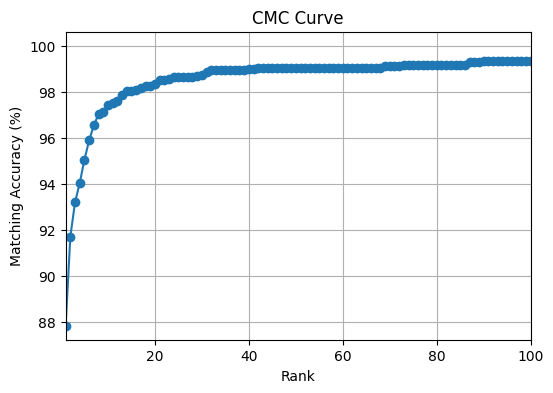

In [69]:
plot_cmc_curve(cmc)